In [14]:
import cv2
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

cell_size = 20

class Cell:
  image = None
  histogram = None
  left = None
  top = None

  def __init__(self, image, row, column, left, top):
    self.image = np.copy(image)
    self.row = row
    self.column = column
    self.top = top
    self.left = left
    self.histogram = self.compute_histogram()

  def compute_histogram(self):
    green_hist = cv2.calcHist([self.image], [1], None, [16], [0, 256])
    red_hist = cv2.calcHist([self.image], [2], None, [16], [0, 256])
    blue_hist = cv2.calcHist([self.image], [0], None, [16], [0, 256])

    green_hist = [x.tolist()[0] for x in green_hist]
    red_hist = [x.tolist()[0] for x in red_hist]
    blue_hist = [x.tolist()[0] for x in blue_hist]

    hist = np.array(green_hist + red_hist + blue_hist)
    return hist/(cell_size * cell_size)
  
  def get_rectangle(self):
    return (self.left, self.top, self.left + cell_size, self.top + cell_size)

class Cluster:
  id = 0
  cells = []
  histogram : np.ndarray = None

  def __init__(self, id: int):
    self.id = id
    self.cells = []

class SingleImage:
  cells = []

  def __init__(self, image):
    (h, w) = image.shape[:2]

    hq = h // cell_size
    wq = w // cell_size

    for i in range(1, (hq + 1)):
      for j in range(1, (wq + 1)):
        left = (i - 1) * cell_size 
        top = (j - 1) * cell_size
        cell_image = image[
            left : left + cell_size,
            top : top + cell_size,
        ]
        #cv2_imshow(cell_image)
        cell = Cell(cell_image, i, j, left, top)
        self.cells.append(cell)

def create_initial_cluster(id, cell) -> Cluster:
  new_cluster = Cluster(id)
  new_cluster.cells.append(cell)
  new_cluster.histogram = np.copy(cell.histogram)
  return new_cluster

def merge_clusters(cluster1: Cluster, cluster2: Cluster, new_cluster_id: int) -> Cluster:
  new_cluster = Cluster(new_cluster_id)
  cluster1_size = len(cluster1.cells)
  cluster2_size = len(cluster2.cells)
  merged_cluster_size = cluster1_size + cluster2_size
  x: np.ndarray = cluster1.histogram * cluster1_size
  y: np.ndarray = cluster2.histogram * cluster2_size
  new_cluster.histogram = (x + y) / merged_cluster_size
  for cell in cluster1.cells:
    new_cluster.cells.append(cell)
  for cell in cluster2.cells:
    new_cluster.cells.append(cell)
  return new_cluster

def euclidean_distance(hist1, hist2):
  distance = sum([(p - q) ** 2 for p, q in zip(hist1, hist2)]) ** 0.5
  return distance

def bhattacharyya_distance(hist1, hist2):
    # Ensure that the histograms have the same number of bins
    assert hist1.shape == hist2.shape
    
    # Convert the histograms to probabilities by dividing each bin by the total number of samples
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Compute the Bhattacharyya distance using the formula:
    # d = sqrt(1 - sum(sqrt(p1 * p2)))
    d = np.sqrt(1 - np.sum(np.sqrt(hist1 * hist2)))
    
    return d

def clusters_are_neighbors(cluster1, cluster2):
  for cell1 in cluster1.cells:
    row1 = cell1.row
    column1 = cell1.column
    for cell2 in cluster2.cells:
      if abs(row1 - cell2.row) <= 1 and abs(column1 - cell2.column) <= 1:
        return True
  return False

def find_clusters_to_merge(clusters, distance_func):
  min_dist = 1.0e12
  min_index1 = -1
  min_index2 = -1
  for cluster_index1 in range(len(clusters)):
    for cluster_index2 in range(cluster_index1+1, len(clusters)):
      cluster1 = clusters[cluster_index1]
      cluster2 = clusters[cluster_index2]

      if not clusters_are_neighbors(cluster1, cluster2):
        continue

      cluster_dist = distance_func(cluster1.histogram, cluster2.histogram)
      if(cluster_dist < min_dist):
        min_index1 = cluster_index1
        min_index2 = cluster_index2
        min_dist = cluster_dist
  return min_index1, min_index2

def merge_two_closest_clusters(clusters, cluster1_id, cluster2_id, new_cluster_id):
  result = []
  for i in range(len(clusters)):
    if i != cluster1_id and i != cluster2_id:
      result.append(clusters[i])
  result.append(merge_clusters(clusters[cluster1_id], clusters[cluster2_id], new_cluster_id))
  return result
  
def hierachical_clustering(all_cells, image, distance_func):
  cluster_id = 0
  clusters = []
  for cell in all_cells:
    clusters.append(create_initial_cluster(cluster_id, cell))
    cluster_id = cluster_id + 1
  show_clusters(clusters, image)
  num_clustering_steps = 0
  while len(clusters) > 1:
    min_index1, min_index2 = find_clusters_to_merge(clusters, distance_func)
    if min_index1 < 0 and min_index2 < 0:
      print("")
      break
    clusters = merge_two_closest_clusters(clusters, min_index1, min_index2, cluster_id)
    cluster_id = cluster_id + 1
    #if cluster_id % 10 == 0:
    show_clusters(clusters, image)
    num_clustering_steps = num_clustering_steps + 1
    if num_clustering_steps > 10:
      break
  show_clusters(clusters, image)
  return clusters

def minimum_bounding_polygon(rectangles):
    # create a list of polygons from the rectangles
    polygons = [
        Polygon([(r[0], r[1]), (r[0], r[3]), (r[2], r[3]), (r[2], r[1])])
        for r in rectangles
    ]

    return polygons[0]
    #print(str(polygons))

    ## create a multipolygon from the polygons
    #multipoly = MultiPolygon(polygons)

    ## return the convex hull of the multipolygon
    #return multipoly.convex_hull


def draw_polygon_on_image(polygons, image) -> None:
    # Convert the image to a NumPy array
    img_array = image #np.array(image)
    print(type(img_array))

    # Create a Matplotlib figure and axes
    plt.figure()
    fig, ax = plt.subplots()
    ax.imshow(img_array)

    for polygon in polygons:
        #print("Hello " + str(polygon))

        # Extract the coordinates of the polygon
        x, y = polygon.exterior.xy

        print("Hello " + str(x) + " " + str(y))

        # Plot the polygon on top of the image
        ax.plot(x, (image.height - y))

    # Show the plot
    #ax.invert_yaxis()
    plt.gca().invert_yaxis()
    #ax.set_ylim(ax.get_ylim()[::-1])

    plt.show()


def show_clusters(clusters, image):
    polygons = []
    for cluster in clusters:
        cell_rectangles = []
        for cell in cluster.cells:
            cell_rectangle = cell.get_rectangle()
            cell_rectangles.append(cell_rectangle)

        polygons.append(minimum_bounding_polygon(cell_rectangles))

    draw_polygon_on_image(polygons, image)

In [11]:
from google.colab import files
uploaded = files.upload()

Saving double_plant_test.png to double_plant_test (1).png


In [12]:
from skimage import io
from io import BytesIO

image = io.imread(BytesIO(uploaded['double_plant_test.png']))
print(type(image))
all_cells = SingleImage(image).cells

<class 'numpy.ndarray'>


Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

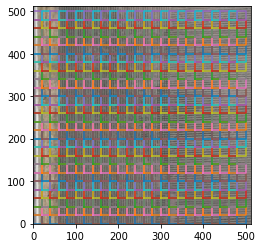

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

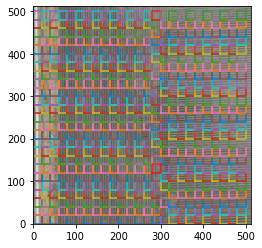

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

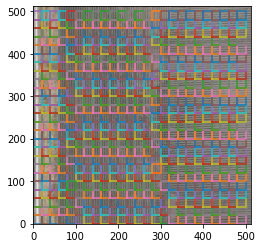

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

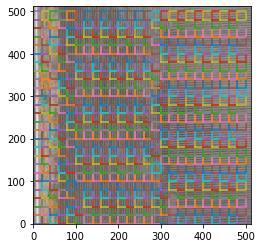

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

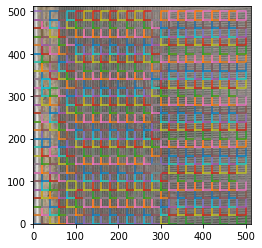

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

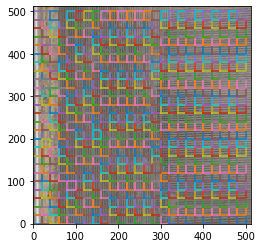

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

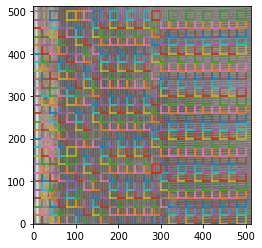

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

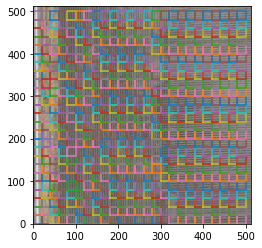

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

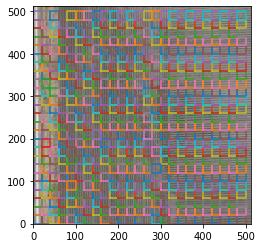

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

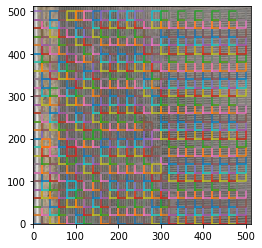

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

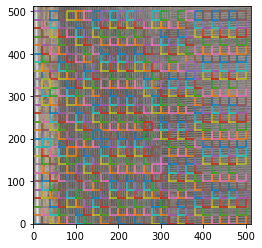

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

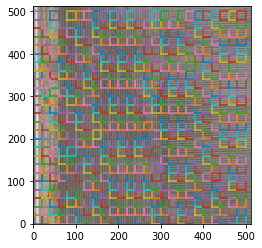

Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [0.0, 20.0, 20.0, 0.0, 0.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [20.0, 40.0, 40.0, 20.0, 20.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [40.0, 60.0, 60.0, 40.0, 40.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [60.0, 80.0, 80.0, 60.0, 60.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [80.0, 100.0, 100.0, 80.0, 80.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [100.0, 120.0, 120.0, 100.0, 100.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [120.0, 140.0, 140.0, 120.0, 120.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [140.0, 160.0, 160.0, 140.0, 140.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [160.0, 180.0, 180.0, 160.0, 160.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [180.0, 200.0, 200.0, 180.0, 180.0])
Hello array('d', [0.0, 0.0, 20.0, 20.0, 0.0]) array('d', [200.0, 220.0, 220.0, 200.0, 

<Figure size 432x288 with 0 Axes>

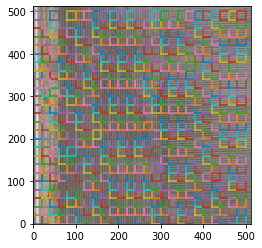

In [6]:
clusters = hierachical_clustering(all_cells, image, bhattacharyya_distance)

<class 'numpy.ndarray'>
Hello array('d', [320.0, 320.0, 340.0, 340.0, 320.0]) array('d', [220.0, 240.0, 240.0, 220.0, 220.0])


AttributeError: ignored

<Figure size 432x288 with 0 Axes>

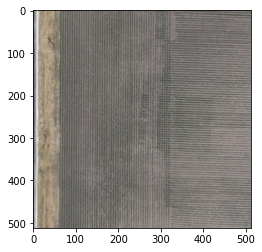

In [15]:
from google.colab.patches import cv2_imshow

for cell in all_cells:
  if(cell.row == 16 and cell.column == 12):
    c_16_12 = cell
  if(cell.row == 17 and cell.column == 12):
    c_17_12 = cell
  if(cell.row == 16 and cell.column == 13):
    c_16_13 = cell
  if(cell.row == 25 and cell.column == 12):
    c_25_12 = cell
  if(cell.row == 1 and cell.column == 12):
    c_1_12 = cell
  if(cell.row == 1 and cell.column == 3):
    c_1_1 = cell

k = Cluster(0)
k.cells.append(c_17_12)
#k.cells.append(c_16_12)
#k.cells.append(c_16_13)
#k.cells.append(c_25_12)
#k.cells.append(c_1_1)
show_clusters([k], image)

#cv2_imshow(c_16_12.image)
#cv2_imshow(c_17_12.image)
#cv2_imshow(c_25_12.image)
#cv2_imshow(c_1_12.image)
#cv2_imshow(c_16_12.image)

#print(c_1_12.left)
#print(c_1_12.top)
#print(c_1_12.get_rectangle())
#print(c_1_12.image)
#print(c_16_12.get_rectangle())

row = 17
column = 12
left = (row - 1) * cell_size 
top = (column - 1) * cell_size
cell_image = image[
            left : left + cell_size,
            top : top + cell_size,
        ]
cv2_imshow(cell_image)

left = c_17_12.left
top = c_17_12.top
r = c_17_12.get_rectangle()
image[r[0] : r[2], r[1] : r[3], : ] = [255, 0, 0]

print(str(r))

cv2_imshow(c_17_12.image)
cv2_imshow(image)

In [ ]:
from google.colab.patches import cv2_imshow

for cell in all_cells:
  cv2_imshow(cell.image)

0.1728431548420339
0.21340593410924322
0.23256719459115466
0.3287856444554719


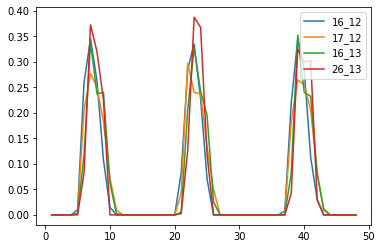

In [ ]:
print(bhattacharyya_distance(c_16_12.histogram, c_17_12.histogram))
print(bhattacharyya_distance(c_16_12.histogram, c_16_13.histogram))

print(euclidean_distance(c_16_12.histogram, c_17_12.histogram))
print(euclidean_distance(c_16_12.histogram, c_16_13.histogram))

import matplotlib.pyplot as plt
x = list(range(1, 49))
plt.plot(x, c_16_12.histogram, label="16_12")
plt.plot(x, c_17_12.histogram, label="17_12")
plt.plot(x, c_16_13.histogram, label="16_13")
plt.plot(x, c_26_13.histogram, label="26_13")
plt.plot()
plt.legend()
plt.show()